In [1]:
# DQN, DDQN

In [2]:
!nvidia-smi

Sat Mar  9 04:29:33 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 418.43       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:0B:00.0 Off |                  N/A |
| 23%   33C    P8     9W / 250W |   1164MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:41:00.0  On |                  N/A |
| 23%   40C    P8    13W / 250W |    883MiB / 12188MiB |     25%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import warnings ; warnings.filterwarnings('ignore')
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import time
import json
import sys
import gym
import io
import os

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 20
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')

%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rc('font', size=24)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

np.set_printoptions(suppress=True)

In [4]:
torch.cuda.is_available()

True

In [5]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, seed=None, unwrapped=False, 
                    monitor_mode=None, addon_wrappers=None):
        mdir = tempfile.mkdtemp()
        env = gym.make(env_name)
        if seed is not None: env.seed(seed)
        env = env.unwrapped if unwrapped else env
        env = wrappers.Monitor(
            env, mdir, force=True, mode=monitor_mode) if monitor_mode else env
        if addon_wrappers:
            for wrapper in addon_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [6]:
def get_videos_html(env_videos, title, max_n_videos=5):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [7]:
def get_gif_html(env_videos, title, max_n_videos=5):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [8]:
class DiscountedCartPole(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def step(self, a):
        o, r, d, _ = self.env.step(a)
        (x, x_dot, theta, theta_dot) = o
        pole_fell =  x < -self.env.unwrapped.x_threshold \
                    or x > self.env.unwrapped.x_threshold \
                    or theta < -self.env.unwrapped.theta_threshold_radians \
                    or theta > self.env.unwrapped.theta_threshold_radians
        r = -1 if pole_fell else 0
        return o, r, d, _

# DQN

In [9]:
class FCQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(
            hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [10]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            return np.argmax(q_values)

In [11]:
class EGreedyStrategy():
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

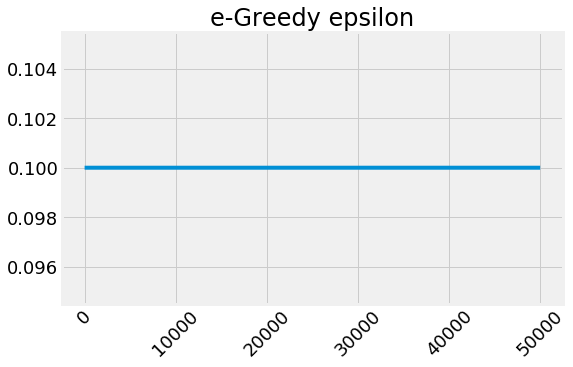

In [12]:
s = EGreedyStrategy()
plt.figure(figsize=(8,5))
plt.plot([s.epsilon for _ in range(50000)])
plt.title('e-Greedy epsilon')
plt.xticks(rotation=45)
plt.show()

In [13]:
class EGreedyLinearStrategy():
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, max_steps=20000):
        self.t = 0
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.min_epsilon = min_epsilon
        self.max_steps = max_steps
        self.exploratory_action_taken = None
        
    def _epsilon_update(self):
        epsilon = 1 - self.t / self.max_steps
        epsilon = (self.init_epsilon - self.min_epsilon) * epsilon + self.min_epsilon
        epsilon = np.clip(epsilon, self.min_epsilon, self.init_epsilon)
        self.t += 1
        return epsilon

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.epsilon = self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

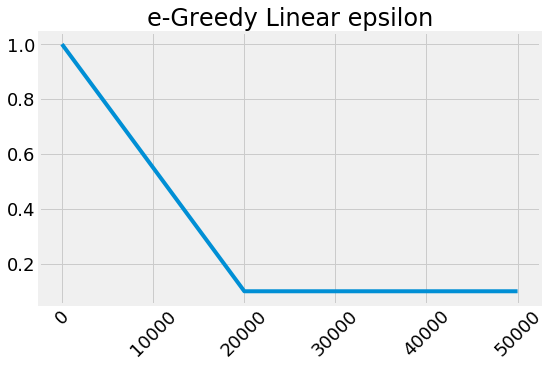

In [14]:
s = EGreedyLinearStrategy()
plt.figure(figsize=(8,5))
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('e-Greedy Linear epsilon')
plt.xticks(rotation=45)
plt.show()

In [15]:
class EGreedyExpStrategy():
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_rate=0.9999):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        self.epsilon = max(self.min_epsilon, self.decay_rate*self.epsilon)
        return self.epsilon

    # def _epsilon_update(self):
    #     self.decay_rate = 0.0001
    #     epsilon = max(self.init_epsilon * np.exp(-self.decay_rate * self.t), 
    #                        self.min_epsilon)
    #     self.t += 1
    #     return epsilon

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).detach().cpu().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

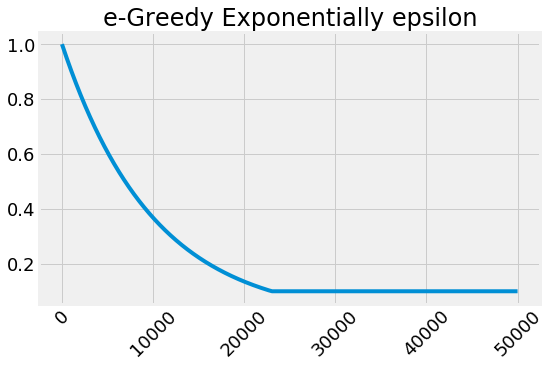

In [16]:
s = EGreedyExpStrategy()
plt.figure(figsize=(8,5))
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('e-Greedy Exponentially epsilon')
plt.xticks(rotation=45)
plt.show()

In [17]:
class SoftMaxStrategy():
    def __init__(self, 
                 init_temp=1.0, 
                 min_temp=0.3, 
                 exploration_ratio=0.8, 
                 max_steps=25000):
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_steps = max_steps
        self.exploratory_action_taken = None
        
    def _update_temp(self):
        temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)
        self.t += 1
        return temp

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        temp = self._update_temp()

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            scaled_qs = q_values/temp
            norm_qs = scaled_qs - scaled_qs.max()            
            e = np.exp(norm_qs)
            probs = e / np.sum(e)
            assert np.isclose(probs.sum(), 1.0)

        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

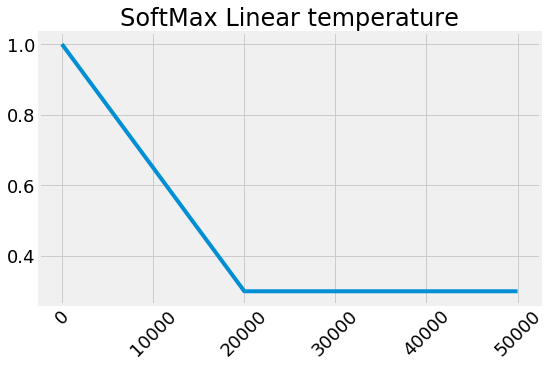

In [18]:
s = SoftMaxStrategy()
plt.figure(figsize=(8,5))
plt.plot([s._update_temp() for _ in range(50000)])
plt.title('SoftMax Linear temperature')
plt.xticks(rotation=45)
plt.show()

In [19]:
class ReplayBuffer():
    def __init__(self, 
                 max_size=10000, 
                 batch_size=64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample):
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

In [20]:
class DQN():
    def __init__(self, 
                 reply_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps):
        self.replay_buffer_fn = replay_buffer_fn
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        max_a_q_sp = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        past_limit_enforced = hasattr(env, '_past_limit') and env._past_limit()
        is_failure = is_terminal and not past_limit_enforced

        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self):
        for target, online in zip(self.target_model.parameters(), 
                                  self.online_model.parameters()):
            target.data.copy_(online.data)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_model = self.value_model_fn(nS, nA)
        self.online_model = self.value_model_fn(nS, nA)
        self.update_network()

        self.value_optimizer = self.value_optimizer_fn(self.online_model, 
                                                       self.value_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn()
        self.evaluation_strategy = evaluation_strategy_fn() 
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()
                
                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(self.online_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained {} Agent', n_episodes=10, max_n_videos=3):          
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

In [21]:
dqn_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    # training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5)
    # training_strategy_fn = lambda: EGreedyLinearStrategy(init_epsilon=1.0,
    #                                                      min_epsilon=0.3, 
    #                                                      max_steps=20000)
    # training_strategy_fn = lambda: SoftMaxStrategy(init_temp=1.0, 
    #                                                min_temp=0.1, 
    #                                                exploration_ratio=0.8, 
    #                                                max_steps=20000)
    training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0,  
                                                      min_epsilon=0.3, 
                                                      decay_rate=0.9999)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=64)
    n_warmup_batches = 5
    update_target_every_steps = 15

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = DQN(replay_buffer_fn,
                value_model_fn,
                value_optimizer_fn,
                value_optimizer_lr,
                training_strategy_fn,
                evaluation_strategy_fn,
                n_warmup_batches,
                update_target_every_steps)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    dqn_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
dqn_results = np.array(dqn_results)
_ = BEEP()

el 00:02, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.4±0.0, ev 019.0±000.0
el 00:22, ep 0127, ts 004587, ar 10 073.8±048.6, 100 040.3±033.2, ex 100 0.5±0.1, ev 233.2±111.8
el 00:43, ep 0177, ts 009697, ar 10 140.6±048.9, 100 076.6±054.8, ex 100 0.4±0.1, ev 219.3±065.3
el 01:03, ep 0210, ts 015151, ar 10 167.6±062.9, 100 116.1±063.5, ex 100 0.3±0.1, ev 212.0±060.2
el 01:23, ep 0230, ts 020358, ar 10 310.6±115.6, 100 154.9±089.8, ex 100 0.2±0.1, ev 239.2±098.3
el 01:43, ep 0241, ts 025257, ar 10 439.9±105.8, 100 193.4±127.7, ex 100 0.2±0.1, ev 273.5±124.5
el 02:04, ep 0251, ts 030087, ar 10 483.0±051.0, 100 235.3±145.8, ex 100 0.2±0.1, ev 301.1±139.8
el 02:25, ep 0262, ts 035124, ar 10 453.7±107.3, 100 273.4±156.7, ex 100 0.2±0.1, ev 330.6±146.0
el 02:45, ep 0275, ts 040307, ar 10 368.3±139.4, 100 309.6±155.5, ex 100 0.2±0.0, ev 366.6±148.2
el 03:06, ep 0286, ts 045659, ar 10 485.2±044.4, 100 345.1±155.3, ex 100 0.2±0.0, ev 397.6±142.2
el 03:27, ep 0299, ts 050851, 


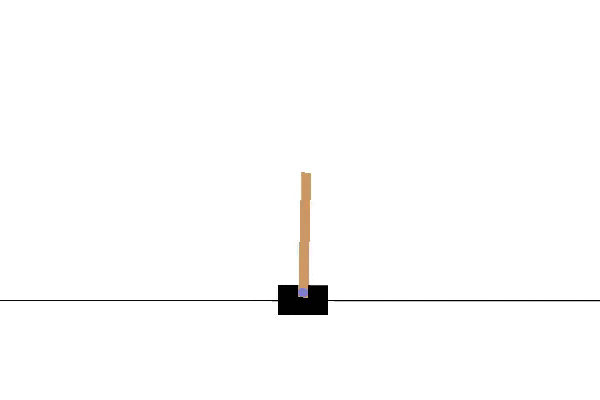
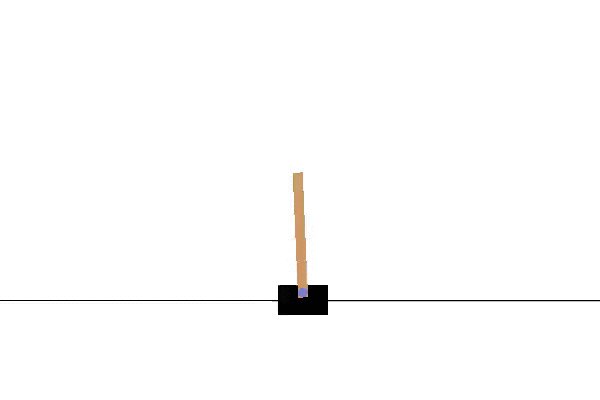
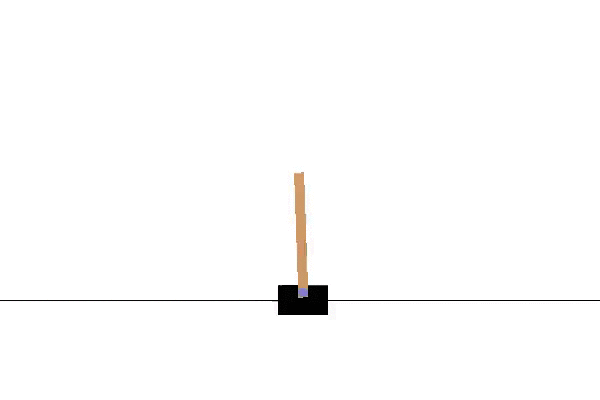

In [22]:
best_agent.demo()

In [23]:
nfq_root_dir = os.path.join(RESULTS_DIR, 'nfq')
nfq_x = np.load(os.path.join(nfq_root_dir, 'x.npy'))

nfq_max_r = np.load(os.path.join(nfq_root_dir, 'max_r.npy'))
nfq_min_r = np.load(os.path.join(nfq_root_dir, 'min_r.npy'))
nfq_mean_r = np.load(os.path.join(nfq_root_dir, 'mean_r.npy'))

nfq_max_s = np.load(os.path.join(nfq_root_dir, 'max_s.npy'))
nfq_min_s = np.load(os.path.join(nfq_root_dir, 'min_s.npy'))
nfq_mean_s = np.load(os.path.join(nfq_root_dir, 'mean_s.npy'))

nfq_max_t = np.load(os.path.join(nfq_root_dir, 'max_t.npy'))
nfq_min_t = np.load(os.path.join(nfq_root_dir, 'min_t.npy'))
nfq_mean_t = np.load(os.path.join(nfq_root_dir, 'mean_t.npy'))

nfq_max_sec = np.load(os.path.join(nfq_root_dir, 'max_sec.npy'))
nfq_min_sec = np.load(os.path.join(nfq_root_dir, 'min_sec.npy'))
nfq_mean_sec = np.load(os.path.join(nfq_root_dir, 'mean_sec.npy'))

nfq_max_rt = np.load(os.path.join(nfq_root_dir, 'max_rt.npy'))
nfq_min_rt = np.load(os.path.join(nfq_root_dir, 'min_rt.npy'))
nfq_mean_rt = np.load(os.path.join(nfq_root_dir, 'mean_rt.npy'))

In [24]:
dqn_max_t, dqn_max_r, dqn_max_s, \
    dqn_max_sec, dqn_max_rt = np.max(dqn_results, axis=0).T
dqn_min_t, dqn_min_r, dqn_min_s, \
    dqn_min_sec, dqn_min_rt = np.min(dqn_results, axis=0).T
dqn_mean_t, dqn_mean_r, dqn_mean_s, \
    dqn_mean_sec, dqn_mean_rt = np.mean(dqn_results, axis=0).T
dqn_x = np.arange(np.max((len(dqn_mean_s), len(nfq_mean_s))))

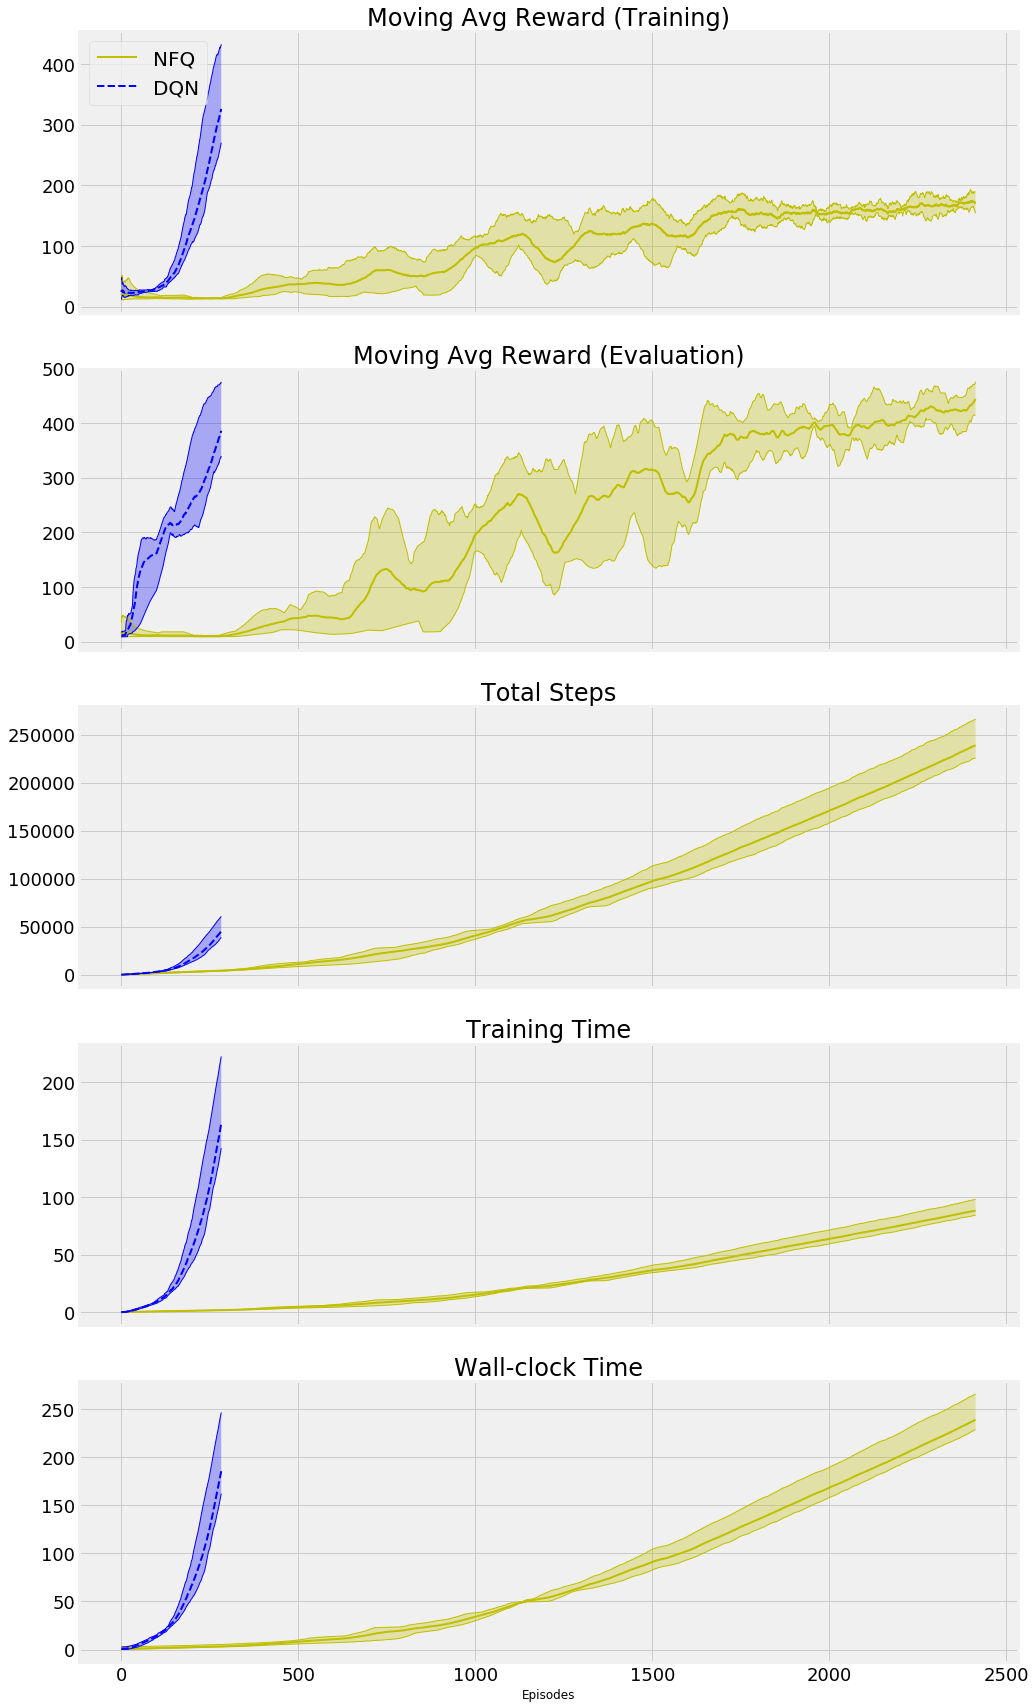

In [25]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [26]:
dqn_root_dir = os.path.join(RESULTS_DIR, 'dqn')
not os.path.exists(dqn_root_dir) and os.makedirs(dqn_root_dir)

np.save(os.path.join(dqn_root_dir, 'x'), dqn_x)

np.save(os.path.join(dqn_root_dir, 'max_r'), dqn_max_r)
np.save(os.path.join(dqn_root_dir, 'min_r'), dqn_min_r)
np.save(os.path.join(dqn_root_dir, 'mean_r'), dqn_mean_r)

np.save(os.path.join(dqn_root_dir, 'max_s'), dqn_max_s)
np.save(os.path.join(dqn_root_dir, 'min_s'), dqn_min_s )
np.save(os.path.join(dqn_root_dir, 'mean_s'), dqn_mean_s)

np.save(os.path.join(dqn_root_dir, 'max_t'), dqn_max_t)
np.save(os.path.join(dqn_root_dir, 'min_t'), dqn_min_t)
np.save(os.path.join(dqn_root_dir, 'mean_t'), dqn_mean_t)

np.save(os.path.join(dqn_root_dir, 'max_sec'), dqn_max_sec)
np.save(os.path.join(dqn_root_dir, 'min_sec'), dqn_min_sec)
np.save(os.path.join(dqn_root_dir, 'mean_sec'), dqn_mean_sec)

np.save(os.path.join(dqn_root_dir, 'max_rt'), dqn_max_rt)
np.save(os.path.join(dqn_root_dir, 'min_rt'), dqn_min_rt)
np.save(os.path.join(dqn_root_dir, 'mean_rt'), dqn_mean_rt)

# Double DQN

In [27]:
pred = np.linspace(-100,100,500)
truth = np.zeros(pred.shape)
error = truth - pred

In [28]:
se = 0.5*error**2
ae = np.abs(error)
he = lambda delta=1: ae - delta/2 if delta == 0 else \
              np.where(ae <= np.repeat(delta, len(ae)), se, delta*(ae - delta/2))

In [29]:
print(np.mean(se))
print(torch.Tensor(error).pow(2).mul(0.5).mean())

1673.3466933867735
tensor(1673.3472)


In [30]:
print(np.mean(ae))
print(torch.Tensor(error).abs().mean())

50.1002004008016
tensor(50.1002)


In [31]:
print(np.mean(he(float('inf'))))
print(np.mean(he(0)))

1673.3466933867735
50.1002004008016


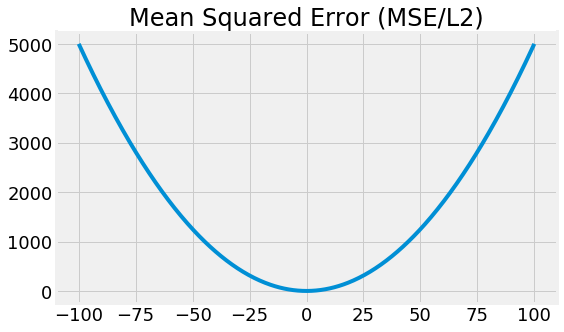

In [32]:
plt.figure(figsize=(8,5))
plt.plot(pred, se)
plt.title('Mean Squared Error (MSE/L2)')
plt.show()

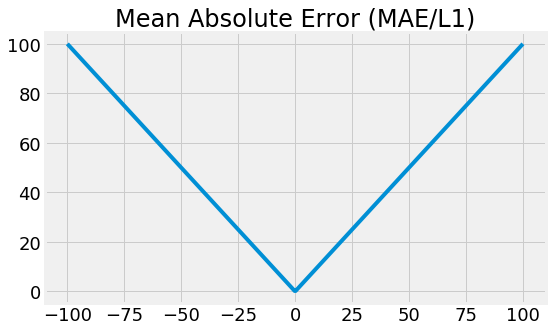

In [33]:
plt.figure(figsize=(8,5))
plt.plot(pred, ae)
plt.title('Mean Absolute Error (MAE/L1)')
plt.show()

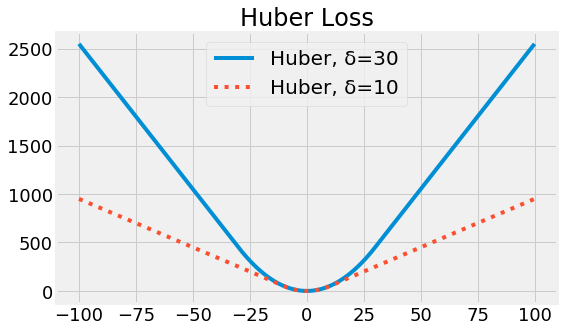

In [34]:
plt.figure(figsize=(8,5))
plot1, = plt.plot(pred, he(30))
plot2, = plt.plot(pred, he(10), ':')
plt.title('Huber Loss')
plt.legend([plot1,plot2],["Huber, δ=30", "Huber, δ=10"])
plt.show()

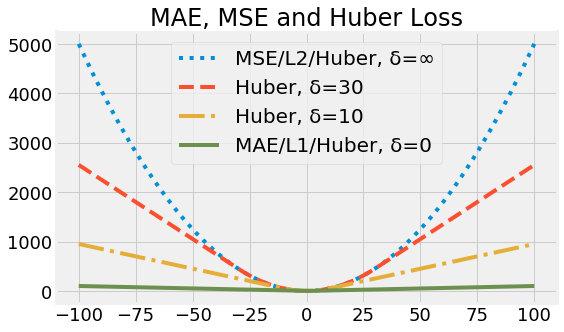

In [35]:
plt.figure(figsize=(8,5))
# plot1, = plt.plot(pred, se, ':')
plot1, = plt.plot(pred, he(float('inf')), ':')
plot2, = plt.plot(pred, he(30), '--')
plot3, = plt.plot(pred, he(10), '-.')
plot4, = plt.plot(pred, he(0))
# plot4, = plt.plot(pred, ae)
plt.title('MAE, MSE and Huber Loss')
plt.legend([plot1,plot2,plot3,plot4],["MSE/L2/Huber, δ=∞", "Huber, δ=30", "Huber, δ=10", "MAE/L1/Huber, δ=0"])
plt.show()

In [36]:
class DDQN():
    def __init__(self, 
                 reply_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 max_gradient_norm,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps):
        self.replay_buffer_fn = replay_buffer_fn
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.max_gradient_norm = max_gradient_norm
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        # argmax_a_q_sp = self.target_model(next_states).max(1)[1]
        argmax_a_q_sp = self.online_model(next_states).max(1)[1]
        q_sp = self.target_model(next_states).detach()
        max_a_q_sp = q_sp[
            np.arange(batch_size), argmax_a_q_sp].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), 
                                       self.max_gradient_norm)
        self.value_optimizer.step()

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        past_limit_enforced = hasattr(env, '_past_limit') and env._past_limit()
        is_failure = is_terminal and not past_limit_enforced

        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self):
        for target, online in zip(self.target_model.parameters(), 
                                  self.online_model.parameters()):
            target.data.copy_(online.data)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_model = self.value_model_fn(nS, nA)
        self.online_model = self.value_model_fn(nS, nA)
        self.update_network()

        self.value_optimizer = self.value_optimizer_fn(self.online_model, 
                                                       self.value_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn()
        self.evaluation_strategy = evaluation_strategy_fn() 
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()

                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(self.online_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained {} Agent', n_episodes=10, max_n_videos=3):          
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

In [37]:
ddqn_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }

    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0007
    max_gradient_norm = float('inf')

    training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0,  
                                                      min_epsilon=0.3, 
                                                      decay_rate=0.9999)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=64)
    n_warmup_batches = 5
    update_target_every_steps = 15
    
    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = DDQN(replay_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 max_gradient_norm,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    ddqn_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
ddqn_results = np.array(ddqn_results)
_ = BEEP()

el 00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.4±0.0, ev 019.0±000.0
el 00:20, ep 0116, ts 003444, ar 10 053.3±028.3, 100 030.6±019.2, ex 100 0.5±0.1, ev 215.8±124.2
el 00:40, ep 0160, ts 007216, ar 10 115.8±073.5, 100 058.2±047.7, ex 100 0.4±0.1, ev 213.3±071.2
el 01:01, ep 0183, ts 011543, ar 10 232.5±066.0, 100 094.2±079.1, ex 100 0.3±0.1, ev 226.3±078.9
el 01:21, ep 0205, ts 015635, ar 10 196.2±069.0, 100 127.9±083.3, ex 100 0.3±0.1, ev 241.7±074.3
el 01:42, ep 0225, ts 019995, ar 10 218.6±048.6, 100 161.1±085.7, ex 100 0.2±0.1, ev 257.7±079.7
el 02:03, ep 0245, ts 024147, ar 10 232.4±074.5, 100 186.4±081.3, ex 100 0.2±0.1, ev 283.1±094.9
el 02:24, ep 0254, ts 028307, ar 10 438.2±094.6, 100 216.3±110.6, ex 100 0.2±0.1, ev 301.7±112.8
el 02:46, ep 0263, ts 032430, ar 10 462.3±097.0, 100 247.5±126.2, ex 100 0.2±0.0, ev 328.3±120.9
el 03:07, ep 0271, ts 036430, ar 10 494.8±015.6, 100 276.3±137.3, ex 100 0.2±0.0, ev 344.1±126.2
el 03:29, ep 0281, ts 040618, 


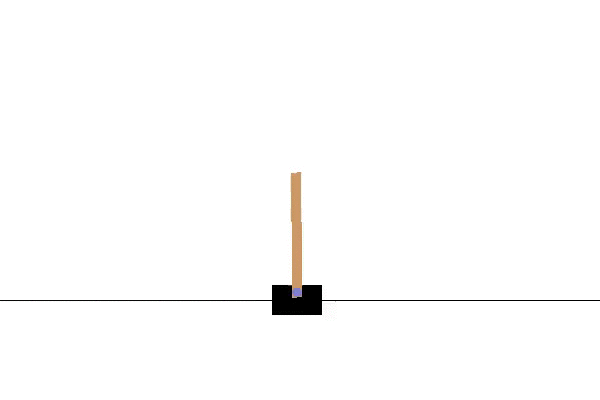
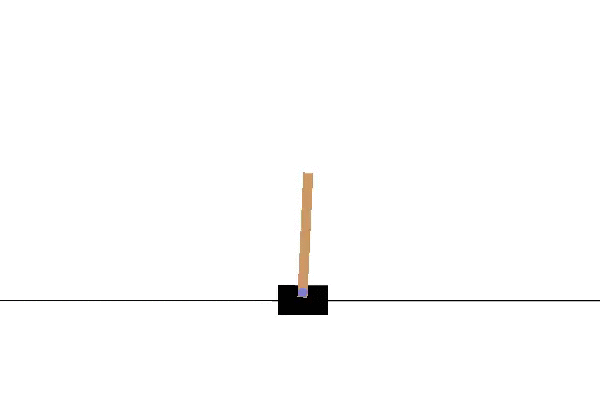
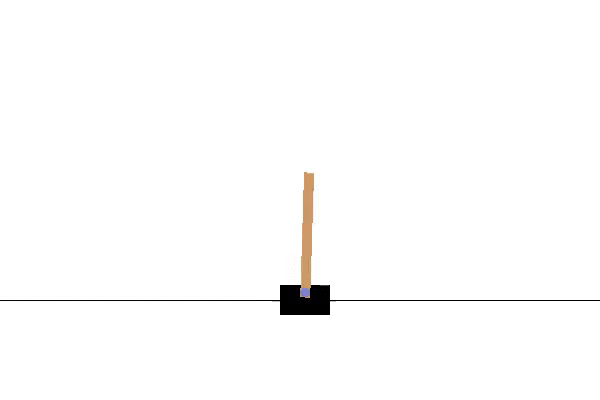

In [38]:
best_agent.demo()

In [39]:
ddqn_max_t, ddqn_max_r, ddqn_max_s, ddqn_max_sec, ddqn_max_rt = np.max(ddqn_results, axis=0).T
ddqn_min_t, ddqn_min_r, ddqn_min_s, ddqn_min_sec, ddqn_min_rt = np.min(ddqn_results, axis=0).T
ddqn_mean_t, ddqn_mean_r, ddqn_mean_s, ddqn_mean_sec, ddqn_mean_rt = np.mean(ddqn_results, axis=0).T
ddqn_x = np.arange(np.max((len(ddqn_mean_s), len(dqn_mean_s))))

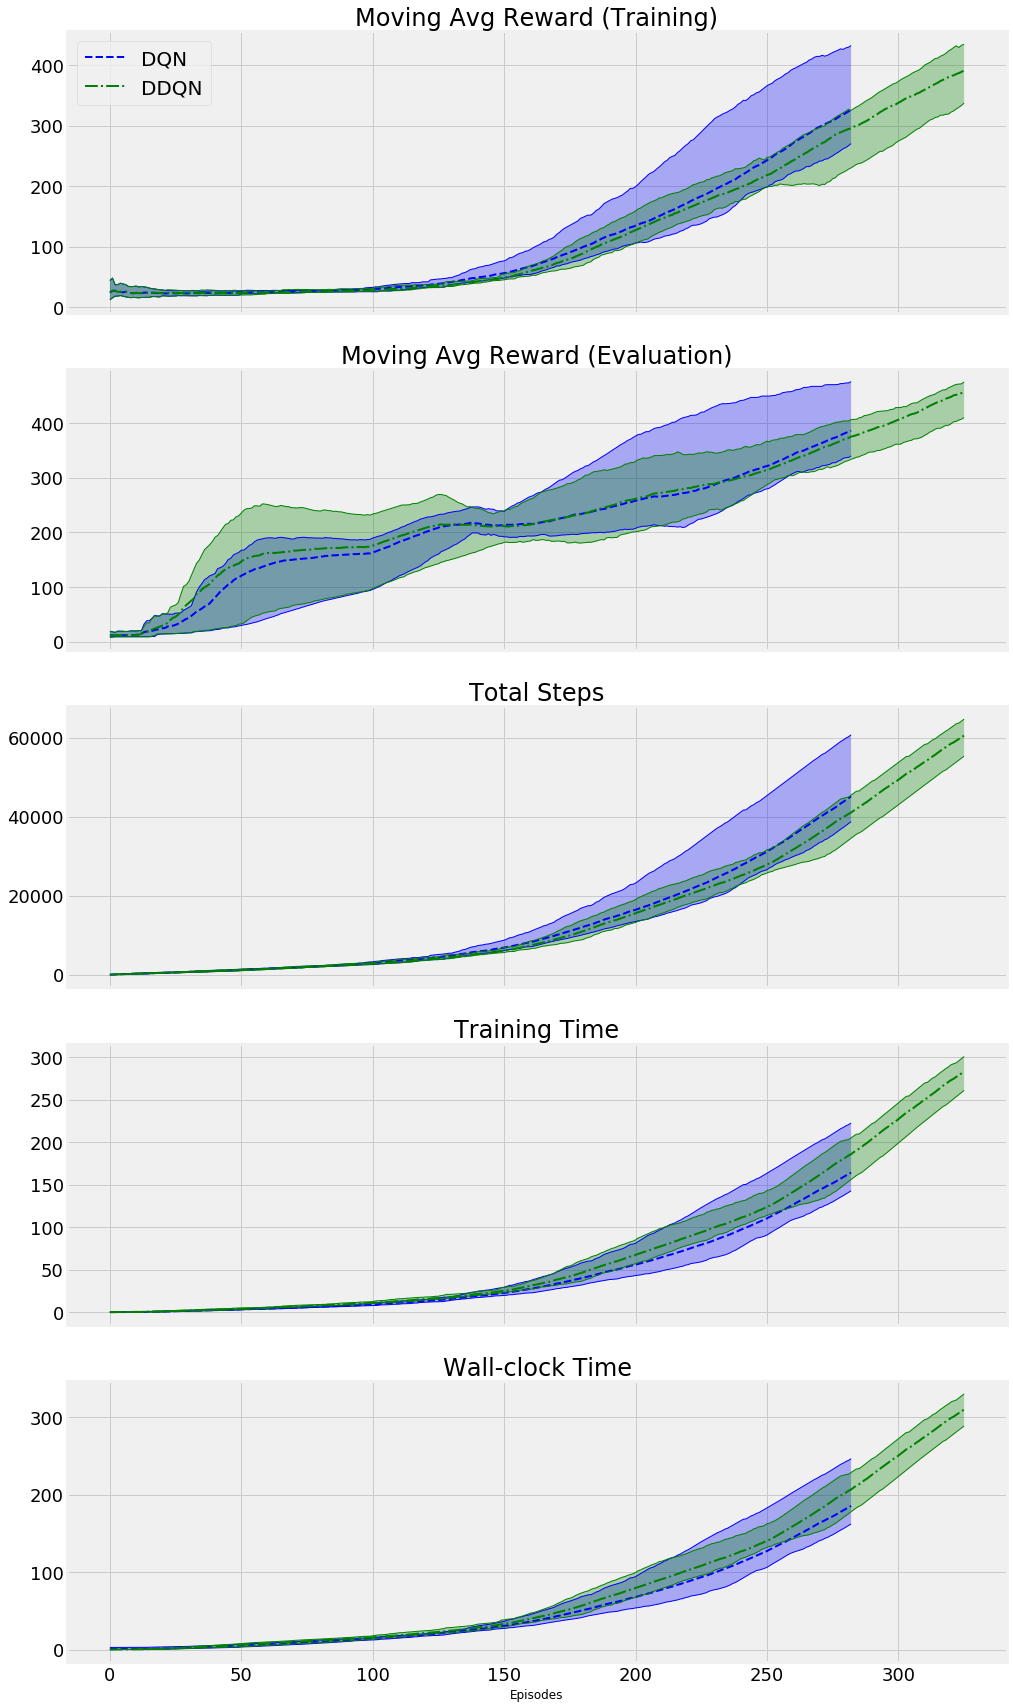

In [40]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# DDQN
axs[0].plot(ddqn_max_r, 'g', linewidth=1)
axs[0].plot(ddqn_min_r, 'g', linewidth=1)
axs[0].plot(ddqn_mean_r, 'g-.', label='DDQN', linewidth=2)
axs[0].fill_between(ddqn_x, ddqn_min_r, ddqn_max_r, facecolor='g', alpha=0.3)

axs[1].plot(ddqn_max_s, 'g', linewidth=1)
axs[1].plot(ddqn_min_s, 'g', linewidth=1)
axs[1].plot(ddqn_mean_s, 'g-.', label='DDQN', linewidth=2)
axs[1].fill_between(ddqn_x, ddqn_min_s, ddqn_max_s, facecolor='g', alpha=0.3)

axs[2].plot(ddqn_max_t, 'g', linewidth=1)
axs[2].plot(ddqn_min_t, 'g', linewidth=1)
axs[2].plot(ddqn_mean_t, 'g-.', label='DDQN', linewidth=2)
axs[2].fill_between(ddqn_x, ddqn_min_t, ddqn_max_t, facecolor='g', alpha=0.3)

axs[3].plot(ddqn_max_sec, 'g', linewidth=1)
axs[3].plot(ddqn_min_sec, 'g', linewidth=1)
axs[3].plot(ddqn_mean_sec, 'g-.', label='DDQN', linewidth=2)
axs[3].fill_between(ddqn_x, ddqn_min_sec, ddqn_max_sec, facecolor='g', alpha=0.3)

axs[4].plot(ddqn_max_rt, 'g', linewidth=1)
axs[4].plot(ddqn_min_rt, 'g', linewidth=1)
axs[4].plot(ddqn_mean_rt, 'g-.', label='DDQN', linewidth=2)
axs[4].fill_between(ddqn_x, ddqn_min_rt, ddqn_max_rt, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [41]:
ddqn_root_dir = os.path.join(RESULTS_DIR, 'ddqn')
not os.path.exists(ddqn_root_dir) and os.makedirs(ddqn_root_dir)

np.save(os.path.join(ddqn_root_dir, 'x'), ddqn_x)

np.save(os.path.join(ddqn_root_dir, 'max_r'), ddqn_max_r)
np.save(os.path.join(ddqn_root_dir, 'min_r'), ddqn_min_r)
np.save(os.path.join(ddqn_root_dir, 'mean_r'), ddqn_mean_r)

np.save(os.path.join(ddqn_root_dir, 'max_s'), ddqn_max_s)
np.save(os.path.join(ddqn_root_dir, 'min_s'), ddqn_min_s )
np.save(os.path.join(ddqn_root_dir, 'mean_s'), ddqn_mean_s)

np.save(os.path.join(ddqn_root_dir, 'max_t'), ddqn_max_t)
np.save(os.path.join(ddqn_root_dir, 'min_t'), ddqn_min_t)
np.save(os.path.join(ddqn_root_dir, 'mean_t'), ddqn_mean_t)

np.save(os.path.join(ddqn_root_dir, 'max_sec'), ddqn_max_sec)
np.save(os.path.join(ddqn_root_dir, 'min_sec'), ddqn_min_sec)
np.save(os.path.join(ddqn_root_dir, 'mean_sec'), ddqn_mean_sec)

np.save(os.path.join(ddqn_root_dir, 'max_rt'), ddqn_max_rt)
np.save(os.path.join(ddqn_root_dir, 'min_rt'), ddqn_min_rt)
np.save(os.path.join(ddqn_root_dir, 'mean_rt'), ddqn_mean_rt)

In [42]:
state = make_env_fn(**make_env_kargs, seed=123).reset()
print(state)

[ 0.02078762 -0.01301236 -0.0209893  -0.03935255]


In [43]:
q_values = best_agent.online_model(state).detach().cpu().numpy()[0]
print(q_values)

[4486640. 4423351.]


In [44]:
q_s = q_values
v_s = q_values.mean()
a_s = q_values - q_values.mean()

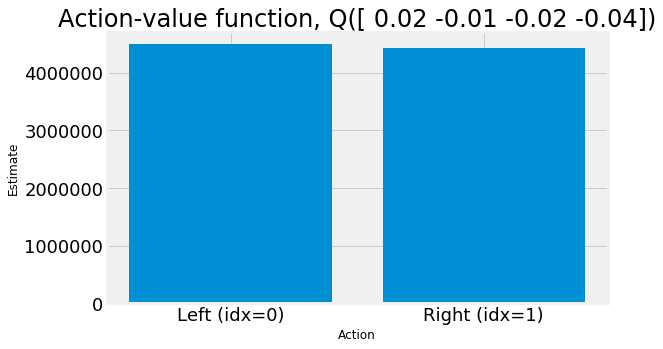

In [45]:
plt.figure(figsize=(8,5))
plt.bar(('Left (idx=0)','Right (idx=1)'), q_s)
plt.xlabel('Action')
plt.ylabel('Estimate')
plt.title("Action-value function, Q(" + str(np.round(state,2)) + ")")
plt.show()

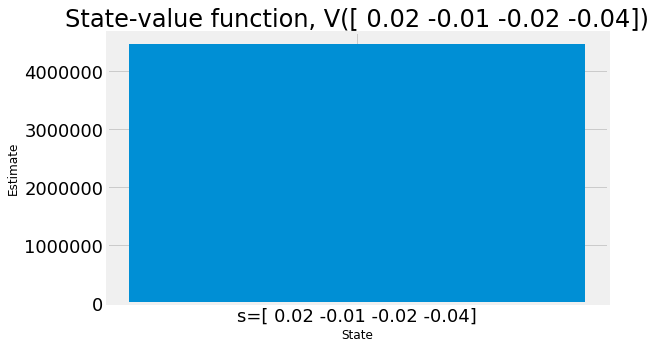

In [46]:
plt.figure(figsize=(8,5))
plt.bar('s='+str(np.round(state,2)), v_s, width=0.1)
plt.xlabel('State')
plt.ylabel('Estimate')
plt.title("State-value function, V("+str(np.round(state,2))+")")
plt.show()

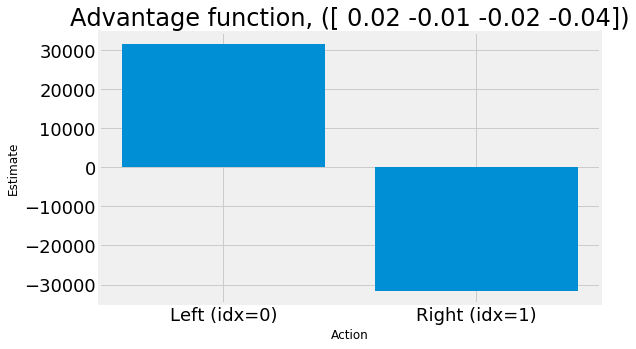

In [47]:
plt.figure(figsize=(8,5))
plt.bar(('Left (idx=0)','Right (idx=1)'), a_s)
plt.xlabel('Action')
plt.ylabel('Estimate')
plt.title("Advantage function, (" + str(np.round(state,2)) + ")")
plt.show()